### Теоретическая вставка

Подобно гауссовской фильтрации и средней фильтрации, оба используют маску и изображение для свертки. Разница в том, что все коэффициенты шаблона среднего фильтра одинаковы, то есть 1. Коэффициент шаблона фильтра Гаусса, по мере увеличения расстояния от центра шаблона коэффициент уменьшается (с учетом двумерного распределения Гаусса). Следовательно, по сравнению со средним фильтром, фильтр Гаусса имеет меньшую степень размытия изображения и может лучше сохранять общие детали изображения.
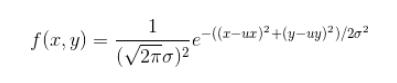

Где (x, y) - координата любой точки в маске, (ux, uy) - координата центральной точки маски, которую можно рассматривать как целое число при обработке изображения; σ - стандартное отклонение.

Например, чтобы сгенерировать шаблон фильтра Гаусса 3 × 3, возьмите центральное положение шаблона как начало координат для выборки. (Ось X расположена горизонтально вправо, а ось Y - вертикально вниз)

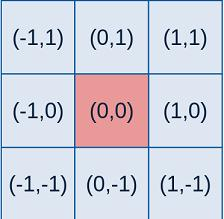

Координаты шаблона в каждой позиции, как показано на рисунке вышt

Таким образом, координаты каждой позиции переводятся в функцию Гаусса, а полученное значение является коэффициентом фильтра.

Если размер шаблона окна равен (2k + 1) × (2k + 1), то:
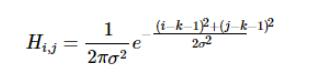

Вычисленный таким образом шаблон имеет две формы: десятичную и целочисленную.

Шаблон в десятичной форме - это значение, полученное прямым вычислением без какой-либо обработки;

Шаблоны в целочисленном формате необходимо нормализовать, а значение в верхнем левом углу шаблона нормализовать до 1. При использовании целочисленного шаблона перед шаблоном необходимо добавить коэффициент, обратный сумме элементов в шаблоне.

Например, стандартное отклонение\sigma = 1.3 Гауссов фильтр целочисленной формы 3 * 3 выглядит следующим образом:
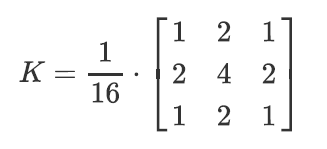

### Значение и выбор σ

Посредством описанного выше процесса реализации нетрудно обнаружить, что наиболее важным параметром для создания шаблона фильтра Гаусса является стандартное отклонение σ распределения Гаусса. Стандартное отклонение представляет собой степень разброса данных.Если σ мало, центральный коэффициент сгенерированного шаблона велик, а окружающие коэффициенты малы, поэтому эффект сглаживания на изображении не очевиден; наоборот, если σ большое, сгенерированный Коэффициенты шаблона не сильно отличаются, они больше похожи на средний шаблон, и эффект сглаживания на изображении более очевиден.
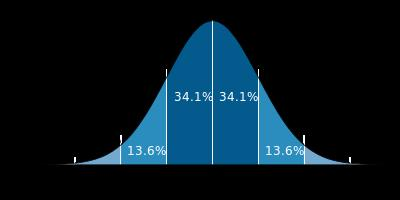

Видно, что чем меньше σ, тем тоньше и выше распределение, чем больше σ, тем короче распределение.

Поскольку длина и ширина изображения не могут быть целыми числами, кратными размеру фильтра, нам нужно заполнить край изображения 0. Этот метод называется заполнением нулями.

In [1]:
import numpy as np
import cv2 as cv
import time
from numba import jit
import matplotlib.pyplot as plt

In [2]:
start = time.time()
cap = cv.VideoCapture('test_Trim.mp4')
fl_to_show=1
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output.avi', fourcc, 20.0, (405,  810),False)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv.resize(frame, (405, 810))

    thresh = cv.GaussianBlur(frame, (5,5), 0)
    out.write(thresh)
    if cv.waitKey(1) == ord('0'):
        if fl_to_show == 1: fl_to_show = 2
        else: fl_to_show = 1
    if fl_to_show == 1:
        frame_to_show = frame   
    else: 
        frame_to_show = thresh
        
    cv.imshow('frame', frame_to_show)
    if cv.waitKey(25) == ord('q'):
        break
cap.release()
out.release()
cv.destroyAllWindows()
end = time.time()
print(round((end-start),2))

4.96


Native

In [3]:
def gaussian_filter(img, K_size, sigma):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        img = np.expand_dims(img, axis=-1)
        H, W, C = img.shape

    ## Zero padding
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2, C), dtype=float)
    out[pad: pad + H, pad: pad + W] = img.copy().astype(float)
 
    ## prepare Kernel
    K = np.zeros((K_size, K_size), dtype=float)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[y + pad, x + pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    K /= (2 * np.pi * sigma * sigma)
    K /= K.sum()
    tmp = out.copy()
 
    # filtering
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[pad + y, pad + x, c] = np.sum(K * tmp[y: y + K_size, x: x + K_size, c])
    out = np.clip(out, 0, 255)
    out = out[pad: pad + H, pad: pad + W].astype(np.uint8)
    return out

In [111]:
start = time.time()
cap = cv.VideoCapture('test_Trim.mp4')
fl_to_show=1
fourcc = cv.VideoWriter_fourcc(*'XVID')
height = 810
width = 405
blocksize = 11
out = cv.VideoWriter('output1.avi', fourcc, 20.0, (width,  height),False)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame2 = frame
    frame = cv.resize(frame, (405, 810))

    thresh = gaussian_filter(frame2,5,1.3)
    thresh = cv.resize(thresh, (width, height))
    frame = cv.resize(frame, (width, height))
    out.write(thresh)
    if cv.waitKey(1) == ord('0'):
        if fl_to_show == 1: fl_to_show = 2
        else: fl_to_show = 1
    if fl_to_show == 1:
        frame_to_show = frame   
    else: 
        frame_to_show = thresh
        
    cv.imshow('frame', frame_to_show)
    if cv.waitKey(25) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()
end = time.time()
print(round((end-start),2))

1117.41


Numba

In [4]:
@jit
def filer1(H, W, C, out, tmp, K_size, K):
    for y in range(H):
        for x in range(W):
            for c in range(C):
                out[K_size // 2 + y, K_size // 2 + x, c] = np.sum(K * tmp[y: y + K_size, x: x + K_size, c])
    return out

In [95]:

# @jit
# def filer(H, W, C, out, tmp, K_size, K):
#     for y in range(H):
#         for x in range(W):
#             for c in range(C):
#                 for yk in range(y, y + K_size):
#                     for xk in range(x, x + K_size):
#                         out[K_size // 2 + y, K_size // 2 + x, c] = out[K_size // 2 + y, K_size // 2 + x, c] + K * tmp[yk, xk, c]
#     return out  

In [5]:
def gaussian_filter_numba(img, K_size, sigma):
    if len(img.shape) == 3:
        H, W, C = img.shape
    else:
        img = np.expand_dims(img, axis=-1)
        H, W, C = img.shape

    ## Zero padding
    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2, C), dtype=float)
    out[pad: pad + H, pad: pad + W] = img.copy().astype(float)
 
    ## prepare Kernel
    K = np.zeros((K_size, K_size), dtype=float)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[y + pad, x + pad] = np.exp( -(x ** 2 + y ** 2) / (2 * (sigma ** 2)))
    K /= (2 * np.pi * sigma * sigma)
    K /= K.sum()
    tmp = out.copy()
 
    # filtering
    out = filer1(H, W, C, out, tmp, K_size, K)
    out = np.clip(out, 0, 255)
    out = out[pad: pad + H, pad: pad + W].astype(np.uint8)
    return out

In [108]:
start = time.time()
cap = cv.VideoCapture('test_Trim.mp4')
fl_to_show=1
fourcc = cv.VideoWriter_fourcc(*'XVID')
height = 810
width = 405
blocksize = 11
out = cv.VideoWriter('output.avi', fourcc, 20.0, (width,  height),False)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv.resize(frame, (405, 810))

    
    thresh = gaussian_filter_numba(frame, 5, 1.3)
    thresh = cv.resize(thresh, (width, height))
    frame = cv.resize(frame, (width, height))
    out.write(thresh)
    if cv.waitKey(1) == ord('0'):
        if fl_to_show == 1: fl_to_show = 2
        else: fl_to_show = 1
    if fl_to_show == 1:
        frame_to_show = frame   
    else: 
        frame_to_show = thresh
        
    cv.imshow('frame', frame_to_show)
    if cv.waitKey(25) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()
end = time.time()
print(round((end-start),2))

30.9


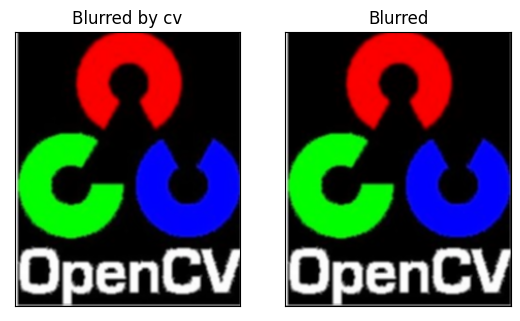

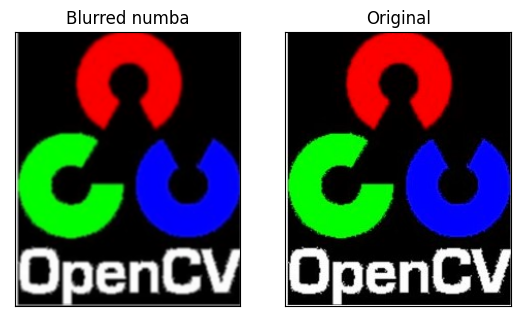

In [9]:
img = cv.imread('gaussian.jpg')
myblur = gaussian_filter(img, 3, 1.3)
myblurnumba = gaussian_filter_numba(img, 3, 1.3)
blur = cv.GaussianBlur(img,(3,3),1.3)


plt.subplot(121),plt.imshow(blur),plt.title('Blurred by cv')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(myblur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(121),plt.imshow(myblurnumba),plt.title('Blurred numba')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.show()

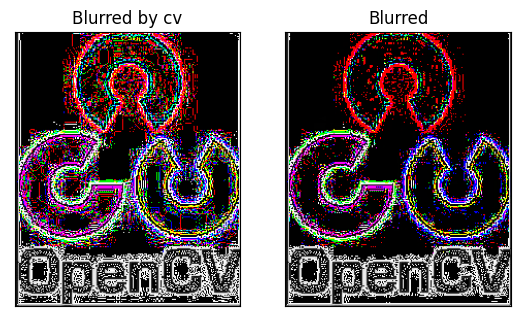

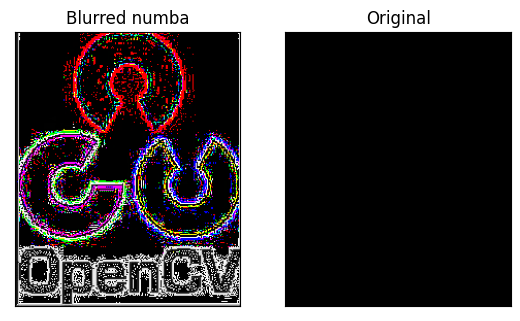

In [10]:
plt.subplot(121),plt.imshow(img - blur),plt.title('Blurred by cv')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img - myblur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(121),plt.imshow(img - myblurnumba),plt.title('Blurred numba')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img - img),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.show()

(([], []), ([], []))

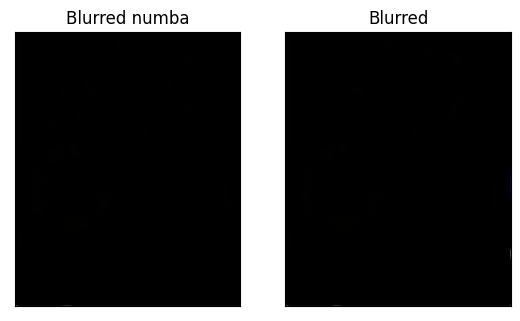

In [12]:
plt.subplot(122),plt.imshow(blur - myblur),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(121),plt.imshow(blur - myblurnumba),plt.title('Blurred numba')
plt.xticks([]), plt.yticks([])